# Reduced Wong-Wang model - PyTorch
Equivalent to the Numba notebook, adapted for PyTorch implementation

In [1]:
import os
import vbi
import warnings
import numpy as np
import pandas as pd
from cmaes import CMA
import networkx as nx
from tqdm import tqdm
from copy import deepcopy
from vbi.utils import timer
import multiprocessing as mp
import matplotlib.pyplot as plt
from multiprocessing import Pool
from vbi.models.pytorch.rww import RWW_sde
from vbi.feature_extraction.features_utils import get_fcd
from vbi.models.pytorch.rww_sde_kong import WW_SDE_KONG

In [2]:
seed = 42
warnings.simplefilter("ignore")
np.random.seed(seed)

In [3]:
LABESSIZE = 10
plt.rcParams["axes.labelsize"] = LABESSIZE
plt.rcParams["xtick.labelsize"] = LABESSIZE
plt.rcParams["ytick.labelsize"] = LABESSIZE

In [4]:
path = "output/r_ww_sde_pytorch_"
os.makedirs(path, exist_ok=True)

- Check compatibility with `rww_sde_kong`:

In [5]:
obj = WW_SDE_KONG()
params = obj.get_default_params()

# convert iterables to numpy arrays float32
for key in params.keys():
    if hasattr(params[key], "__len__") and not isinstance(params[key], str):
        params[key] = np.array(params[key]).astype(np.float32)

for key in params.keys():
    # print key and value shape if is iterable else print value
    if hasattr(params[key], "__len__") and not isinstance(params[key], str):
        print(f"{key}: {np.array(params[key]).shape}, type: {(params[key].dtype)}")
    else:
        print(f"{key}: {params[key]}")

# --- update default parameters ---
par = RWW_sde.get_default_parameters()
common_keys = set(par.keys()).intersection(set(params.keys()))
different_keys = set(par.keys()).symmetric_difference(set(params.keys()))

print(common_keys)
print(different_keys)

for key in common_keys:
    par[key] = params[key]
par['sigma'] = params['s']
par['I_ext'] = params['I0']
par['gamma'] = params['gamma_s']
par['integration_method'] = 'euler'
par['device'] = 'cuda'
par['RECORD_BOLD'] = True
par['warmup_steps'] = 1000

G: 6.270336254908696
J: 0.2609
w: (68,), type: float32
s: (68,), type: float32
I0: (68,), type: float32
a: 270.0
b: 108.0
d: 0.154
tau_s: 0.1
gamma_s: 0.641
t_end: 300.0
t_cut: 120.0
tr: 0.72
dt: 0.01
n_sim: 1
weights: (68, 68), type: float32
device: cpu
dtype: torch.float64
{'a', 'weights', 'J', 'dt', 'G', 'n_sim', 't_end', 'tau_s', 'device', 't_cut', 'b', 'tr', 'd', 'w'}
{'integration_method', 'warmup_steps', 'I0', 'sigma', 'seed', 'gamma', 'I_ext', 'gamma_s', 'dtype', 'RECORD_BOLD', 's'}


In [6]:
def wrapper(par, **kwargs):
    """Wrapper function to run the WW_sde model with given parameters."""
    par = deepcopy(par)
    sde = RWW_sde(par)
    verbose = kwargs.get("verbose", False)
    record_neural = kwargs.get("record_neural", False)
    neural_subsample = kwargs.get("neural_subsample", 5)
    data = sde.run(
        verbose=verbose, record_neural=record_neural, neural_subsample=neural_subsample
    )
    bold_d = data["bold_d"].cpu().numpy()  # Convert to numpy
    bold_t = data["bold_t"].cpu().numpy()

    neural_d = None
    neural_t = None
    if record_neural:
        neural_d = data["S"].cpu().numpy()
        neural_t = data["t"].cpu().numpy()

    
    return bold_t, bold_d, neural_t, neural_d


In [7]:
ww = RWW_sde(par)
print(ww)

Reduced Wong-Wang Neural Mass Model (PyTorch)
Network: 68 nodes, 1 parameter sets
Device: cuda
Integration method: euler

Neural Model Parameters:
------------------------------------------------------------------------------------------
Parameter    | Definition                     | Value/Shape                             
------------------------------------------------------------------------------------------
w            | Recurrent strength             | shape [68, 1]                           
I_ext        | External input                 | shape [68, 1]                           
G            | Global coupling                | 6.27034                                 
sigma        | Noise amplitude                | shape [68, 1]                           
J            | Synaptic coupling              | 0.2609                                  
a            | Firing rate slope              | 270                                     
b            | Firing rate threshold          | 

In [8]:
ww = RWW_sde(par)
bold_t, bold_d, neural_t, neural_d = wrapper(
    par, 
    verbose=True, 
    record_neural=True,
    neural_subsample=2
    )

Warm-up ...:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating ...: 100%|██████████| 30001/30001 [00:53<00:00, 555.63it/s]

BOLD simulation completed in 55.20 seconds


(68, 1, 250) (250,) (68, 1, 9000) (9000,) False


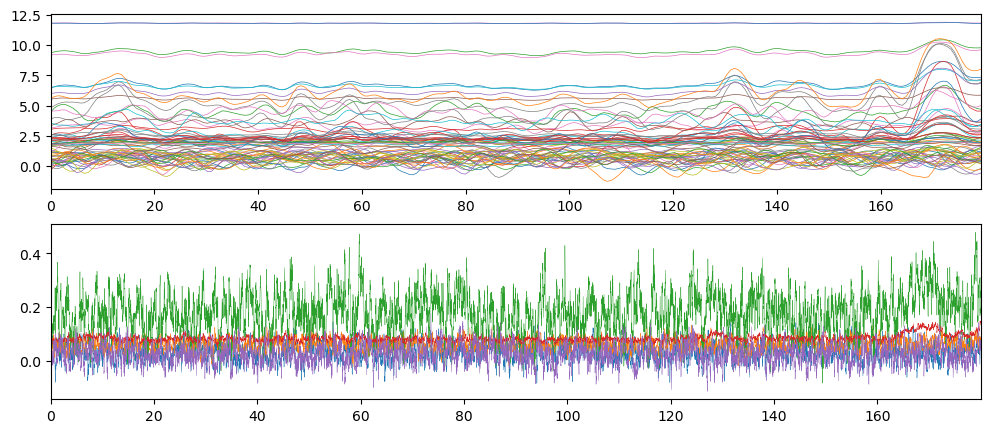

In [9]:
print(bold_d.shape, bold_t.shape, neural_d.shape, neural_t.shape, np.isnan(bold_d).any())  # (nnodes, nsim, nsamples)
fig, ax = plt.subplots(2, figsize=(12, 5))
ax[0].plot(bold_t, bold_d[:,0,:].T, lw=0.5, alpha=1.0);
ax[0].margins(x=0)
ax[1].plot(neural_t, neural_d[:5,0,:].T, lw=0.3, alpha=1.0);
ax[1].margins(x=0)
plt.show()

In [10]:
def compute_cost(
    bold_d,
    fc_target=None,
    fcd_target=None,
    add_cost_fc=True,
    add_cost_fcd=True,
    zscore_fc=False,
    zscore_fcd=False,
):
    """Compute the cost between simulated and target BOLD signals.

    Parameters
    ----------
    bold_d : np.ndarray
        Simulated BOLD data. Shape: (n_timepoints, n_regions)
    """
    # Compute costs here
    cost = 0.0
    return cost


def wrapper(par, **kwargs):
    """Wrapper function to run the WW_sde model with given parameters."""
    par = deepcopy(par)
    sde = RWW_sde(par)
    verbose = kwargs.get("verbose", False)
    record_neural = kwargs.get("record_neural", False)
    get_cost = kwargs.get("get_cost", False)
    neural_subsample = kwargs.get("neural_subsample", 5)
    data = sde.run(
        verbose=verbose, record_neural=record_neural, neural_subsample=neural_subsample
    )
    bold_d = data["bold_d"].cpu().numpy()  # Convert to numpy
    bold_t = data["bold_t"].cpu().numpy()

    neural_d = None
    neural_t = None
    if record_neural:
        neural_d = data["S"].cpu().numpy()
        neural_t = data["t"].cpu().numpy()

    if not get_cost:
        return bold_t, bold_d, neural_t, neural_d
    else:
        add_cost_fc = kwargs.get("add_cost_fc", True)
        add_cost_fcd = kwargs.get("add_cost_fcd", True)
        zscore_fc = kwargs.get("zscore_fc", False)
        zscore_fcd = kwargs.get("zscore_fcd", False)
        cost = compute_cost(
            bold_d,
            fc_target=None,
            fcd_target=None,
            add_cost_fc=add_cost_fc,
            add_cost_fcd=add_cost_fcd,
            zscore_fc=zscore_fc,
            zscore_fcd=zscore_fcd,
        )

    return cost

In [11]:
# # Gs = np.arange(0.1, 2.3, 0.05)
# Gs = np.array([0.1])
# par = dict(
#     weights=weights,
#     dt=2.5,  # s
#     t_end=0.5 * 60 * 1000.0,  # ms
#     t_cut=0.1 * 60 * 1000.0,  # ms
#     G=Gs,
#     sigma=0.05, #0.05
#     I0=0.05,   #0.05
#     tr=300.0,  # s
#     device="cpu",
#     n_sim=len(Gs),
#     integration_method="heun",
# )
# ww = RWW_sde(par)
# bold_t, bold_d, neural_t, neural_d = wrapper(
#     par, 
#     verbose=True, 
#     record_neural=True,
#     neural_subsample=2
#     )